# Joint Named Entity Recognition and Relation Extraction using DSPY

## Default definition for model usage and imports

In [1]:
import dspy
import nest_asyncio
from pydantic import BaseModel, Field
from dspy.functional import TypedPredictor
from IPython.display import Markdown, display
import seaborn as sns
from typing import List, Optional, Union
from dotenv import load_dotenv
from devtools import pprint
import os
from tqdm import tqdm
import pickle

import json
import pandas as pd
assert load_dotenv('/work3/s174159/LLM_Thesis/prompt/.env') == True


In [2]:
API = os.getenv('OPENAI')
HF = os.getenv("HF")

In [6]:
gpt = dspy.OpenAI(model='gpt-4o-mini', max_tokens=2048, api_key=API)
gpt4 = dspy.OpenAI(model='gpt-4', max_tokens=2048, api_key= API)
gpt3 = dspy.OpenAI(model='gpt-3.5-turbo', max_tokens=2048, api_key=API)


# Set default model
dspy.settings.configure(lm=gpt)

## Create sample dataset and test data

In [7]:
LOAD_FROM_FILES = False

In [8]:
SAMPLE_SIZE = 50

In [9]:
if LOAD_FROM_FILES:
    test_input = pd.read_json("/work3/s174159/LLM_Thesis/data/Final/Combined/test_sampled.json")
    dev_input = pd.read_json("/work3/s174159/LLM_Thesis/data/Final/Combined/dev_sampled.json")
    sampled_df = pd.read_json("/work3/s174159/LLM_Thesis/data/Final/Combined/train_sampled.json")

df1 = pd.read_json('/work3/s174159/LLM_Thesis/data/Final/Combined/train_annotated.json')
#df2 = pd.read_json("/work3/s174159/LLM_Thesis/data/No_Constraints/Data_Finalized/Combined/train_distant.json")
dataframes = [df1]
df = pd.concat(dataframes)
df['org_dataset'].value_counts()

org_dataset
NYT         56196
ReDocRED     3053
CrossRE      1940
CoNLL04       922
SciERC        350
Name: count, dtype: int64

In [10]:
def sample_equal_per_class(df, sample_size, column_name):
    unique_classes = df[column_name].unique()
    n_samples_per_class = sample_size // len(unique_classes)  # Equal samples per class

    sampled_df = pd.DataFrame()

    # Sample equal number of samples from each class
    for category in unique_classes:
        sampled_df = pd.concat([sampled_df, df[df[column_name] == category].sample(n=n_samples_per_class, random_state=42)])

    return sampled_df.sample(frac=1).reset_index(drop=True)


In [11]:
def sample_with_distribution(df, sample_size, column_name): 
    proportions = df[column_name].value_counts(normalize=True)

    samples_per_class = (proportions * sample_size).round().astype(int)

    sampled_df = pd.DataFrame()

    # Sample from each class accourding to samples. 
    for category, n_samples in samples_per_class.items():
        sampled_df = pd.concat([sampled_df, df[df[column_name] == category].sample(n=n_samples, random_state=42)])
    

    return sampled_df.sample(frac=1).reset_index(drop=True)


In [12]:
if not LOAD_FROM_FILES:
    sampled_df = sample_equal_per_class(df, SAMPLE_SIZE, 'org_dataset')

<Figure size 1000x600 with 0 Axes>

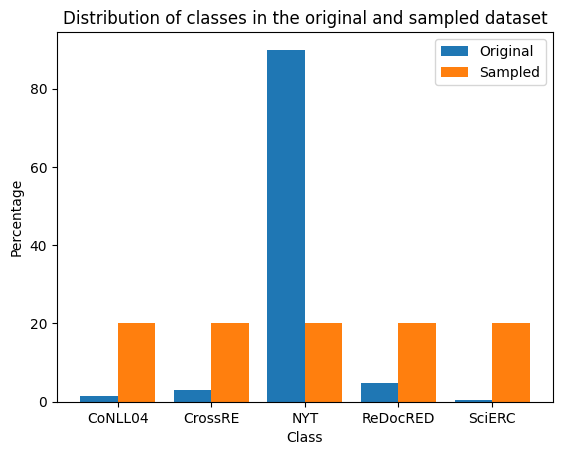

In [13]:
import matplotlib.pyplot as plt

original_distribution = df['org_dataset'].value_counts(normalize=True) * 100
sampled_distribution = sampled_df['org_dataset'].value_counts(normalize=True) * 100


distribution_df = pd.DataFrame({'Original': original_distribution, 'Sampled': sampled_distribution}).sort_index()

plt.figure(figsize=(10, 6))
distribution_df.plot(kind='bar', width=0.8)
plt.title('Distribution of classes in the original and sampled dataset')
plt.ylabel('Percentage')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.show()

In [14]:
# Prepare the DSPY dataset
dataset = []
for org_dataset, title, domains, sents, vertexSet, labels, original_file_path in tqdm(sampled_df.values, total=len(sampled_df), desc="Creating dataset - Processing row"):
    # Convert JSON strings to Python objects
    sents = (sents)
    vertexSet = (vertexSet)
    labels = (labels)
    
    entity_types = list(set([entity['type'] for entity_list in vertexSet for entity in entity_list]))
    relation_types = list(set([relation['r'] for relation in labels]))
    
    # Create a DSPY example and append to the dataset
    example = dspy.Example(
        sentences=str(sents), 
        entities=vertexSet, 
        relations=labels
    ).with_inputs('sentences', 'entity_types', 'relation_types')

    # Attach entity_types and relation_types to the example
    example['entity_types'] = str(entity_types)
    example['relation_types'] = str(relation_types)
    
    dataset.append(example)

# Now the dataset is ready for use with DSPY
print(f"Total examples created: {len(dataset)}")

# Check one example to see the structure
print(dataset[0])


Creating dataset - Processing row: 100%|██████████| 50/50 [00:00<00:00, 37543.00it/s]

Total examples created: 50
Example({'sentences': '[[\'Henry\', \'A.\', \'Grunwald\', \',\', \'a\', \'refugee\', \'from\', \'Nazi-dominated\', \'Austria\', \'who\', \'rose\', \'to\', \'become\', \'Time\', \'magazine\', "\'s", \'top\', \'editor\', \'and\', \'later\', \'returned\', \'to\', \'Vienna\', \'as\', \'the\', \'United\', \'States\', \'ambassador\', \',\', \'died\', \'yesterday\', \'at\', \'his\', \'home\', \'in\', \'Manhattan\', \'.\']]', 'entities': [[{'name': 'Austria', 'pos': [8, 9], 'type': 'Location', 'sent_id': 0}], [{'name': 'Vienna', 'pos': [22, 23], 'type': 'Location', 'sent_id': 0}], [{'name': 'United States', 'pos': [25, 27], 'type': 'Location', 'sent_id': 0}], [{'name': 'Manhattan', 'pos': [35, 36], 'type': 'Location', 'sent_id': 0}]], 'relations': [{'h': 0, 't': 1, 'r': 'Contains location', 'evidence': [0]}, {'h': 1, 't': 0, 'r': 'Located in', 'evidence': [0]}, {'h': 0, 't': 1, 'r': 'Located in', 'evidence': [0]}, {'h': 0, 't': 1, 'r': 'Capital', 'evidence': [0]}], '

In [15]:
if not LOAD_FROM_FILES:
    dev_input = pd.read_json("/work3/s174159/LLM_Thesis/data/Final/Combined/dev.json")
    dev_input = sample_equal_per_class(dev_input, SAMPLE_SIZE, 'org_dataset')

In [16]:
# Prepare the DSPY dataset
dev_data = []
for org_dataset, title, domains, sents, vertexSet, labels, original_file_path in tqdm(dev_input.values, total=len(dev_input), desc="Creating dataset - Processing row"):
    # Convert JSON strings to Python objects
    sents = (sents)
    vertexSet = (vertexSet)
    labels = (labels)
    
    # Extract entity types and relation types for the current row
    entity_types = list(set([entity['type'] for entity_list in vertexSet for entity in entity_list]))
    relation_types = list(set([relation['r'] for relation in labels]))
    
    # Create a DSPY example and append to the dataset
    example = dspy.Example(
        sentences=str(sents), 
        entities=vertexSet, 
        relations=labels
    ).with_inputs('sentences', 'entity_types', 'relation_types')

    # Attach entity_types and relation_types to the example
    example['entity_types'] = str(entity_types)
    example['relation_types'] = str(relation_types)
    
    dev_data.append(example)

# Now the dataset is ready for use with DSPY
print(f"Total examples created: {len(dev_data)}")

# Check one example to see the structure
print(dev_data[0])


Creating dataset - Processing row: 100%|██████████| 50/50 [00:00<00:00, 29183.86it/s]

Total examples created: 50
Example({'sentences': '[[\'Shulman\', \',\', \'Art\', \'Dynamo\', \'-\', \'Country\', \'Style\', \'(\', \'1956\', \')\', \',\', \'TV\', \'Guide\', \',\', \'p\', \',\', \'28\', \'The\', \'late\', \'1950s\', \'saw\', \'the\', \'emergence\', \'of\', \'Buddy\', \'Holly\', \',\', \'but\', \'by\', \'the\', \'end\', \'of\', \'the\', \'decade\', \',\', \'backlash\', \'as\', \'well\', \'as\', \'traditional\', \'artists\', \'such\', \'as\', \'Ray\', \'Price\', \',\', \'Marty\', \'Robbins\', \',\', \'and\', \'Johnny\', \'Horton\', \'began\', \'to\', \'shift\', \'the\', \'industry\', \'away\', \'from\', \'the\', \'rock\', \'n\', "\'", \'roll\', \'influences\', \'of\', \'the\', \'mid-1950s\', \'.\']]', 'entities': [[{'name': 'Shulman , Art', 'pos': [0, 3], 'type': 'Person', 'sent_id': 0}], [{'name': 'Dynamo - Country Style', 'pos': [3, 7], 'type': 'Other', 'sent_id': 0}], [{'name': 'Buddy Holly', 'pos': [24, 26], 'type': 'Album', 'sent_id': 0}], [{'name': 'Ray Price', 'po

In [17]:
if not LOAD_FROM_FILES:
    test_input = pd.read_json("/work3/s174159/LLM_Thesis/data/Final/Combined/test.json")
    test_input = sample_equal_per_class(test_input, SAMPLE_SIZE, 'org_dataset')

In [18]:
if not LOAD_FROM_FILES:
    test_input.to_json("/work3/s174159/LLM_Thesis/data/Final/Combined/test_sampled.json")
    dev_input.to_json("/work3/s174159/LLM_Thesis/data/Final/Combined/dev_sampled.json")
    sampled_df.to_json("/work3/s174159/LLM_Thesis/data/Final/Combined/train_sampled.json")

In [19]:
# Prepare the DSPY dataset
test_data = []
for org_dataset, title, domains, sents, vertexSet, labels, original_file_path in tqdm(test_input.values, total=len(test_input), desc="Creating dataset - Processing row"):
    # Convert JSON strings to Python objects
    sents = (sents)
    vertexSet = (vertexSet)
    labels = (labels)
    
    # Extract entity types and relation types for the current row
    entity_types = list(set([entity['type'] for entity_list in vertexSet for entity in entity_list]))
    relation_types = list(set([relation['r'] for relation in labels]))
    
    # Create a DSPY example and append to the dataset
    example = dspy.Example(
        sentences=str(sents), 
        entities=vertexSet, 
        relations=labels
    ).with_inputs('sentences', 'entity_types', 'relation_types')

    # Attach entity_types and relation_types to the example
    example['entity_types'] = str(entity_types)
    example['relation_types'] = str(relation_types)
    
    test_data.append(example)

# Now the dataset is ready for use with DSPY
print(f"Total examples created: {len(test_data)}")

# Check one example to see the structure
print(test_data[0])


Creating dataset - Processing row: 100%|██████████| 50/50 [00:00<00:00, 29967.88it/s]

Total examples created: 50
Example({'sentences': "[['The', 'same', 'year', 'the', 'Euskadiko', 'Ezkerra', 'sent', 'Juan', 'María', 'Bandrés', '(', 'only', 'Euskadiko', 'Ezkerra', 'senator', ')', 'to', 'the', 'Basque', 'General', 'Council', '(', 'the', 'preautonomic', 'Basque', 'government', 'and', 'the', 'decision', 'of', 'Euskadiko', 'Ezkerra', 'of', 'voting', 'to', 'the', 'candidate', 'of', 'the', 'Basque', 'Nationalist', 'Party', '(', 'PNV', ')', 'to', 'the', 'presidency', 'of', 'the', 'council', ',', 'precipitated', 'the', 'decision', 'of', 'EMK', ',', 'that', 'left', 'Euskadiko', 'Ezkerra', ',', 'along', 'with', 'the', 'OIC-EKE', '(', 'which', 'in', '1979', 'would', 'eventually', 'be', 'integrated', 'in', 'EMK', ')', '.']]", 'entities': [[{'name': 'Euskadiko Ezkerra', 'pos': [4, 6], 'type': 'Policital party', 'sent_id': 0}], [{'name': 'Juan María Bandrés', 'pos': [7, 10], 'type': 'Politician', 'sent_id': 0}], [{'name': 'Basque General Council', 'pos': [18, 21], 'type': 'Organizati

## Define DSPY Signatures

In [20]:
class Entity_extractor(dspy.Signature):
    """Extract entities from a provided text based on specified entity types.
    The output is a list of tuples in the format (entity, type, location, evidence), where:
    - 'entity' is the extracted term,
    - 'type' is its classification (e.g., Person, Location),
    - 'location' is the index range within the text where the entity is found, represented as a list [Start, End],
    - 'evidence' is a list of indices indicating the specific sublists (within the list of lists) that contain the entity."""
    
    sentences = dspy.InputField(description="A list of lists, where each inner list contains text segments to extract entities from.", type=str, required=True)
    entity_types = dspy.InputField(description="The types of entities to extract (e.g., Person, Location, Organization).", type=str, required=True)
    answer = dspy.OutputField(description="A string representing the list of extracted entities in the format (entity, type, location, evidence).", type=str)



class TupleToJson(dspy.Signature):
    """Convert extracted entity tuples into JSON format.
    The output is a list of dictionaries, each containing:
    - 'entity': the extracted term,
    - 'type': its classification (e.g., Person, Location),
    - 'location': the index range within the text where the entity is found,
    - 'evidence': a list of indices indicating the sublists containing the entity.
    The output should be formatted as a JSON list."""
    
    text = dspy.InputField(description="Input text containing extracted entities in tuple format, i.e., (entity, type, location, evidence).", type=str, required=True)
    answer = dspy.OutputField(description="JSON-formatted output as a list of dictionaries. Remember to include [ ] to mark the list", type=str)


    
class RelationExtractor(dspy.Signature):
    """
    Given the text in form of Python lists of sentences, a list of dictionaries with entities and a list of relation types find the relations between the entities.
    The output should be  a list of tuples in the format (entity1, entity2, relation), where:
    - 'entity1' and 'entity2' are the names or terms representing the two entities involved,
    - 'relation' is the specific relationship type between them, as defined in the provided relation types. Use the exact types as defined in the input field, relation_types. 
    This format captures the relationships directly as they appear in the text."""
    
    entities = dspy.InputField(description="A list of entities in dictionary format [{'entity': name, 'type': entity_type, 'location': index}].", type=str, required=True)
    sentences = dspy.InputField(description="The original text containing the entities to identify relationships between them.", type=str, required=True)
    relation_types = dspy.InputField(description="Optional: Specific types of relationships to extract between the entities (e.g., Parent-Child, Colleague).", type=str, required=False)
    answer = dspy.OutputField(description="A string representing the list of identified relations in the format (entity1, entity2, relation).", type=str)

class TupleToJsonRelation(dspy.Signature):
    """Convert text into a structured JSON format representing relationships between entities.
    The output should be a list of dictionaries, each containing:
    - 'entity1': the first entity in the relationship,
    - 'entity2': the second entity in the relationship,
    - 'relation': the type of relationship between the entities.
    The output should be formatted as a JSON list."""
    
    text = dspy.InputField(description="Input text containing entity relationships described in natural language.", type=str, required=True)
    answer = dspy.OutputField(description="JSON-formatted output as a list of dictionaries, where each dictionary contains 'entity1', 'entity2', and 'relation type'. Do not include ```json tags. But only the json list itself", type=str)





In [21]:
class CoTRelationExtraction(dspy.Module):
    def __init__(self):
        super().__init__()
        self.entity_extraction = dspy.ChainOfThought(Entity_extractor)
        self.tuple_to_json = dspy.ChainOfThought(TupleToJson)
        self.relation_extraction = dspy.ChainOfThought(RelationExtractor)
        self.tuple_to_json_relation = dspy.ChainOfThought(TupleToJsonRelation)
        
        
    
    def forward(self, sentences, entity_types, relation_types):
        entities = self.entity_extraction(sentences=sentences, entity_types=entity_types)
        entities = entities.answer.split("---")[0]
        entities = self.tuple_to_json(text=entities)
        entities = str(entities.answer)
        relations = self.relation_extraction(entities=entities, sentences=sentences, relation_types = relation_types)
        # print(relations)
        relations = relations.answer.split("---")[0]
        # print(relations)
        relations = self.tuple_to_json_relation(text=relations)
        relations = str(relations.answer)
        # print(relations)
        return str(relations)
    

In [22]:
rel_extractor = CoTRelationExtraction()

In [23]:
from sklearn.metrics import f1_score, precision_score, recall_score
import ast
import json


def relation_f1_score(expected, predicted, trace=None):
    def parse_input(input_data):
        if isinstance(input_data, str):
            try:
                # Try to parse as JSON
                return json.loads(input_data)
            except json.JSONDecodeError:
                try:
                    # Fallback to ast.literal_eval
                    return ast.literal_eval(input_data)
                except (ValueError, SyntaxError):
                    # Return None if both parsing attempts fail
                    return None
        elif isinstance(input_data, dict):
            # Wrap dict in a list
            return [input_data]
        return input_data

    # Parse expected and predicted inputs
    expected = parse_input(expected)
    predicted = parse_input(predicted)

    # print("Predicted", predicted)



    expected_relations = set()

    
    entities = expected.entities
    relations = expected.relations
    
    flat_entities = [entity for sublist in entities for entity in sublist]
    for rel in relations:
        entity1_name = flat_entities[rel['h']]['name']
        entity2_name = flat_entities[rel['t']]['name']
        relation_type = rel['r']
        expected_relations.add((entity1_name, entity2_name, relation_type))
    
    # print("expected relations", expected_relations)
    
    # Extract predicted relations
    predicted_relations = {
        (rel['entity1'], rel['entity2'], rel['relation'])
        for rel in predicted
    }


    # Create binary labels for true/false positives
    y_true = [1 if rel in expected_relations else 0 for rel in predicted_relations]
    y_pred = [1] * len(predicted_relations)  # All predicted relations are labeled as 1

    # Handle case where there are no true relations in expected
    if not y_true:
        return 0

    # Calculate F1 Score
    f1 = f1_score(y_true, y_pred, zero_division=0)
    if not f1:
        return 0
    return f1 #,expected_relations, predicted_relations



In [24]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import ast
import json
import numpy as np
scores_rels = []
results = []


def combined_relation_f1_score(expected, predicted, trace=None):
    """ 
        The following is only used to establish a baseline and thus re-trace the steps!
    """
    def parse_input(input_data):
        if isinstance(input_data, str):
            try:
                # Try to parse as JSON
                return json.loads(input_data)
            except json.JSONDecodeError:
                try:
                    # Fallback to ast.literal_eval
                    return ast.literal_eval(input_data)
                except (ValueError, SyntaxError):
                    # Return None if both parsing attempts fail
                    return None
        elif isinstance(input_data, dict):
            # Wrap dict in a list
            return [input_data]
        return input_data

    # Parse expected and predicted inputs
    expected = parse_input(expected)
    predicted = parse_input(predicted)

    # Handle case where predicted or expected is None or empty
    if predicted is None or len(predicted) == 0 or expected is None or len(expected) == 0:
        # Return zero-valued metrics
        return {
            'micro_f1': 0,
            'micro_precision': 0,
            'micro_recall': 0,
            'macro_f1': 0,
            'macro_precision': 0,
            'macro_recall': 0,
            'accuracy': 0,
            'class_metrics': {}
        }

    expected_relations = set()

    # Extract expected relations from entities and relations
    entities = expected.get('entities', [])
    relations = expected.get('relations', [])
    
    flat_entities = [entity for sublist in entities for entity in sublist]
    for rel in relations:
        entity1_name = flat_entities[rel['h']]['name']
        entity2_name = flat_entities[rel['t']]['name']
        relation_type = rel['r']
        expected_relations.add((entity1_name, entity2_name, relation_type))
    
    # Extract predicted relations
    predicted_relations = {
        (rel['entity1'], rel['entity2'], rel['relation'])
        for rel in predicted
    }

    # Create all possible labels for binary classification (1 if relation is in expected, 0 otherwise)
    all_relations = list(expected_relations | predicted_relations)

    y_true = [1 if rel in expected_relations else 0 for rel in all_relations]
    y_pred = [1 if rel in predicted_relations else 0 for rel in all_relations]

    # Check if y_true and y_pred are non-empty before calculating metrics
    if len(y_true) == 0 or len(y_pred) == 0:
        return {
            'micro_f1': 0,
            'micro_precision': 0,
            'micro_recall': 0,
            'macro_f1': 0,
            'macro_precision': 0,
            'macro_recall': 0,
            'accuracy': 0,
            'class_metrics': {}
        }

    # Calculate metrics
    metrics = {}

    # Micro F1, precision, recall
    metrics['micro_f1'] = f1_score(y_true, y_pred, average='micro', zero_division=0)
    metrics['micro_precision'] = precision_score(y_true, y_pred, average='micro', zero_division=0)
    metrics['micro_recall'] = recall_score(y_true, y_pred, average='micro', zero_division=0)

    # Macro F1, precision, recall
    metrics['macro_f1'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['macro_precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['macro_recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)

    # Per-class metrics (F1, precision, recall)
    unique_classes = sorted(set([rel[2] for rel in all_relations]))  # Classes are relation types
    class_metrics = {cls: {} for cls in unique_classes}
    
    for i, cls in enumerate(unique_classes):
        y_true_class = [1 if rel[2] == cls and rel in expected_relations else 0 for rel in all_relations]
        y_pred_class = [1 if rel[2] == cls and rel in predicted_relations else 0 for rel in all_relations]

        class_metrics[cls]['f1'] = f1_score(y_true_class, y_pred_class, zero_division=0)
        class_metrics[cls]['precision'] = precision_score(y_true_class, y_pred_class, zero_division=0)
        class_metrics[cls]['recall'] = recall_score(y_true_class, y_pred_class, zero_division=0)
        class_metrics[cls]['accuracy'] = accuracy_score(y_true_class, y_pred_class)

    metrics['class_metrics'] = class_metrics

    # Overall accuracy
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    scores_rels.append(metrics)  # For the parallelization
    return metrics

### Check of the samples

In [25]:
dataset[0].inputs()['relation_types']

"['Capital', 'Located in', 'Contains location']"

In [26]:
from collections import Counter
relations_type_counter = Counter()

for sample in dataset: 
    relation_types = sample.inputs()['relation_types']
    relations_type_counter.update(ast.literal_eval(relation_types))

relation_types_count = dict(relations_type_counter)
print(relation_types_count)

{'Capital': 4, 'Located in': 12, 'Contains location': 8, 'Part of': 3, 'Conjunction': 2, 'Evaluate for': 6, 'Used for': 10, 'Compare': 5, 'Feature of ': 4, 'Kill': 2, 'Producer': 1, 'Notable work': 4, 'Spouse': 1, 'Publication date': 5, 'Production company': 1, 'Director': 2, 'Date of death': 4, 'Instance of': 1, 'Physical': 3, 'Contains adminstrative territorial entity': 3, 'Inception': 3, 'Country': 7, 'Official language': 2, 'Subsidiary': 1, 'Parent organization': 1, 'Location': 1, 'Owned by': 1, 'Live in': 3, 'General affiliation': 3, 'Hyponym of': 3, 'Head of government': 1, 'Date of birth': 5, 'Member of': 1, 'Head of state': 1, 'Conflict': 1, 'Start time': 1, 'Applies to jurisdiction': 1, 'Participant': 1, 'Country of citizenship': 4, 'Point in time': 1, 'Ethnic group': 1, 'End time': 1, 'Employer': 1, 'Present in work': 2, 'Performer': 2, 'Works for': 2, 'Named': 3, 'Win defeat': 2, 'Artifact': 2, 'Neighborhood': 1, 'Related to': 2, 'Nationality': 1, 'Country of origin': 2, 'Fo

In [27]:
len(set(list(relation_types_count.keys())))

64

In [28]:
original_test_set_types = set(list(relation_types_count.keys()))

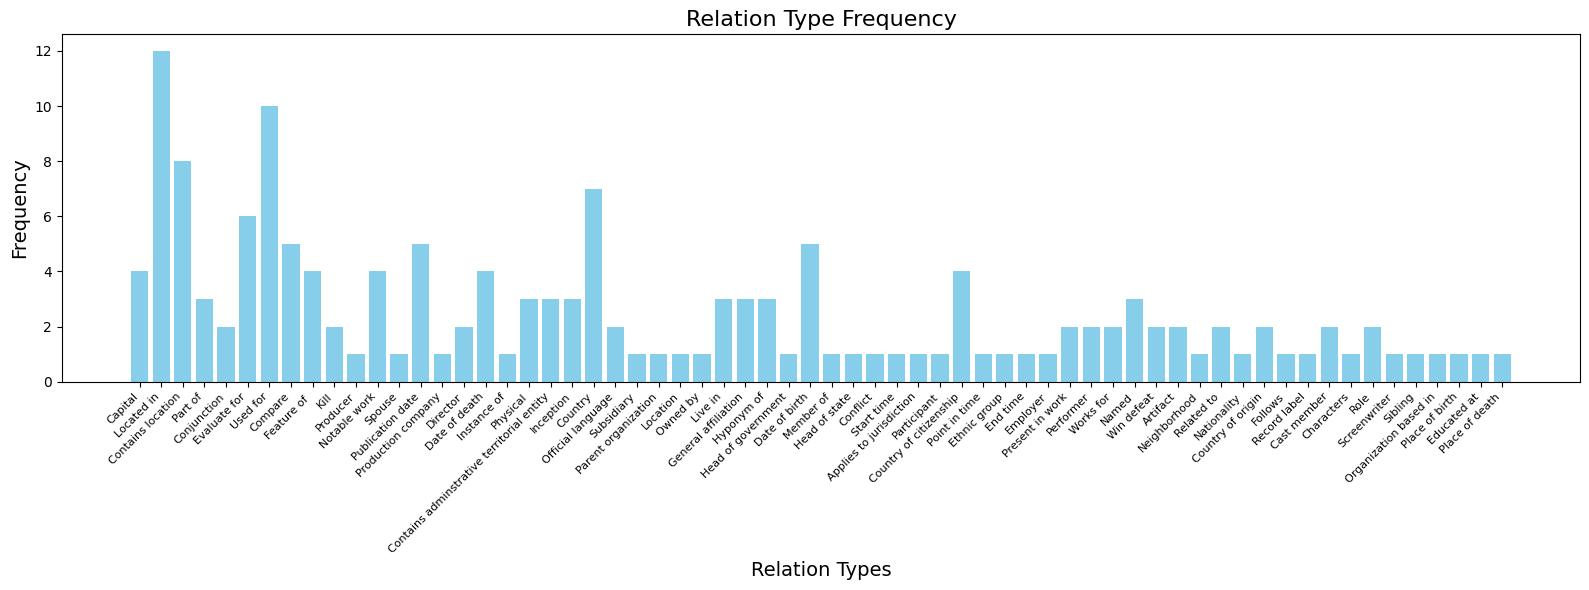

In [29]:
# Convert dictionary keys and values into separate lists for plotting
x_values = list(relation_types_count.keys())
y_values = list(relation_types_count.values())

# Set the style for the plot
plt.figure(figsize=(16, 6))
plt.bar(x_values, y_values, color="skyblue")

# Add title and labels
plt.title('Relation Type Frequency', fontsize=16)
plt.xlabel('Relation Types', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize = 8)  # Rotate x labels for better readability

# Display the plot
plt.tight_layout()
plt.show()





## Baseline scoring


In [30]:
scores_rels = []
results = []

for x in tqdm(test_data[:1], desc="Evaluating test data -- Setting baseline"):
    pred = rel_extractor(**x.inputs())
    score= combined_relation_f1_score(x, pred)
    scores_rels.append(score)

Evaluating test data -- Setting baseline: 100%|██████████| 1/1 [00:25<00:00, 25.56s/it]


In [31]:
def sort_data(scores_rels):
    # Create a list of dictionaries for the general metrics
    general_metrics_data = []
    for item in scores_rels:
        general_metrics_data.append({
            'micro_f1': item['micro_f1'],
            'micro_precision': item['micro_precision'],
            'micro_recall': item['micro_recall'],
            'macro_f1': item['macro_f1'],
            'macro_precision': item['macro_precision'],
            'macro_recall': item['macro_recall'],
            'accuracy': item['accuracy']
        })

    # Convert to a DataFrame
    general_metrics_df = pd.DataFrame(general_metrics_data)


        # Create a list for class-specific metrics
    class_metrics_data = []
    for item in scores_rels:
        for class_name, metrics in item['class_metrics'].items():
            class_metrics_data.append({
                'class': class_name,
                'f1': metrics['f1'],
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'accuracy': metrics['accuracy']
            })

    # Convert to a DataFrame
    class_metrics_df = pd.DataFrame(class_metrics_data)
    return general_metrics_df, class_metrics_df



In [32]:
general_metrics_df, class_metrics_df = sort_data(scores_rels)

In [33]:
general_metrics_df.describe()

,micro_f1,micro_precision,micro_recall,macro_f1,macro_precision,macro_recall,accuracy
count,2.000,2.000,2.000,2.000000,2.000000,2.000000,2.000
mean,0.125,0.125,0.125,0.111111,0.166667,0.083333,0.125
std,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000
min,0.125,0.125,0.125,0.111111,0.166667,0.083333,0.125
25%,0.125,0.125,0.125,0.111111,0.166667,0.083333,0.125
50%,0.125,0.125,0.125,0.111111,0.166667,0.083333,0.125
75%,0.125,0.125,0.125,0.111111,0.166667,0.083333,0.125
max,0.125,0.125,0.125,0.111111,0.166667,0.083333,0.125


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics(general_metrics_df, class_metrics_df):
    # Set the style for the plots
    sns.set(style="whitegrid")

    # Plot for General Metrics
    fig, axes = plt.subplots(2, 3, figsize=(30, 10))
    fig.suptitle('General Metrics over Experiments', fontsize=16)
    
    metrics = ['micro_f1', 'micro_precision', 'micro_recall', 'macro_f1', 'macro_precision', 'macro_recall']
    
    for idx, metric in enumerate(metrics):
        row = idx // 3
        col = idx % 3
        axes[row, col].plot(general_metrics_df.index, general_metrics_df[metric], marker='o')
        axes[row, col].set_title(metric)
        axes[row, col].set_xlabel('Experiment')
        axes[row, col].set_ylabel(metric)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot for Class-Specific Metrics
    unique_classes = class_metrics_df['class'].unique()

    for metric in ['f1', 'precision', 'recall', 'accuracy']:
        plt.figure(figsize=(30, 6))
        sns.barplot(data=class_metrics_df, x='class', y=metric)
        plt.title(f'Class-Specific {metric.capitalize()}')
        plt.xlabel('Class')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()




In [35]:
def plot_metrics_with_class_occurrences_and_f1(general_metrics_df, class_metrics_df, class_occurrences_dict):
    # Set the style for the plots
    sns.set(style="whitegrid")

    # Plot for General Metrics
    fig, axes = plt.subplots(2, 3, figsize=(30, 10))
    fig.suptitle('General Metrics over Experiments', fontsize=16)
    
    metrics = ['micro_f1', 'micro_precision', 'micro_recall', 'macro_f1', 'macro_precision', 'macro_recall']
    
    for idx, metric in enumerate(metrics):
        row = idx // 3
        col = idx % 3
        axes[row, col].plot(general_metrics_df.index, general_metrics_df[metric], marker='o')
        axes[row, col].set_title(metric)
        axes[row, col].set_xlabel('Experiment')
        axes[row, col].set_ylabel(metric)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot for Class-Specific Metrics
    unique_classes = class_metrics_df['class'].unique()

    for metric in ['f1', 'precision', 'recall', 'accuracy']:
        plt.figure(figsize=(30, 6))
        sns.barplot(data=class_metrics_df, x='class', y=metric)
        plt.title(f'Class-Specific {metric.capitalize()}')
        plt.xlabel('Class')
        plt.ylabel(metric.capitalize())
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()

    # Create a new DataFrame that includes the F1 scores and the class occurrences
    class_f1_scores = class_metrics_df.groupby('class')['f1'].mean().reindex(class_occurrences_dict.keys())
    combined_df = pd.DataFrame({
        'class': list(class_occurrences_dict.keys()),
        'occurrences': list(class_occurrences_dict.values()),
        'f1_score': class_f1_scores
    })

    # Plot for Class Occurrences with F1 scores
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot occurrences on the left y-axis
    ax1.bar(combined_df['class'], combined_df['occurrences'], color="lightblue", label="Occurrences")
    ax1.set_xlabel('Class', fontsize=14)
    ax1.set_ylabel('Number of Occurrences', fontsize=14, color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")
    plt.xticks(rotation=45, ha="right")

    # Plot F1 scores on the right y-axis
    ax2 = ax1.twinx()
    ax2.plot(combined_df['class'], combined_df['f1_score'], color="red", marker='o', label="F1 Score")
    ax2.set_ylabel('F1 Score', fontsize=14, color="red")
    ax2.tick_params(axis='y', labelcolor="red")

    # Add title
    plt.title('Number of Times Each Class Occurs with Corresponding F1 Score', fontsize=16)

    plt.tight_layout()
    plt.show()

# Example usage:
# plot_metrics_with_class_occurrences_and_f1(general_metrics_df, class_metrics_df, relation_type_counts)



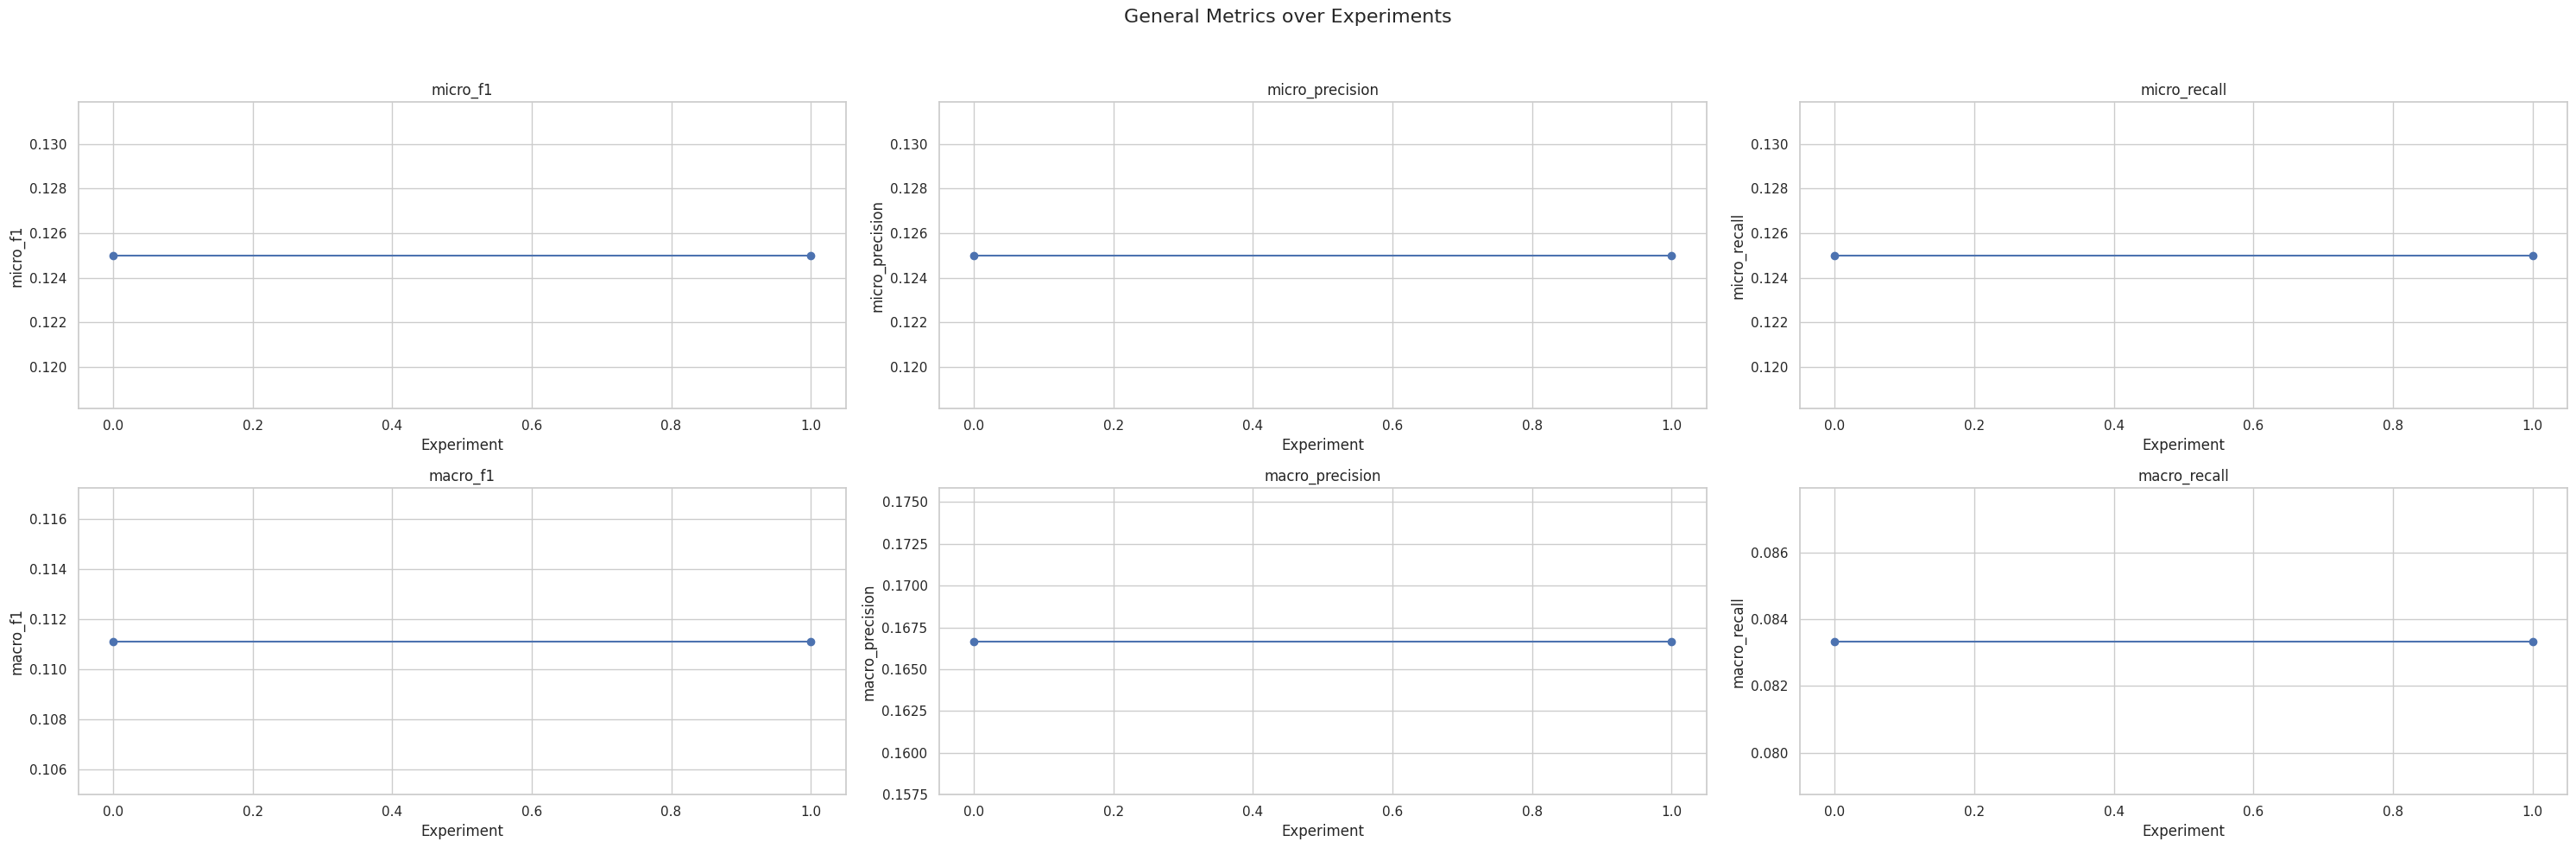

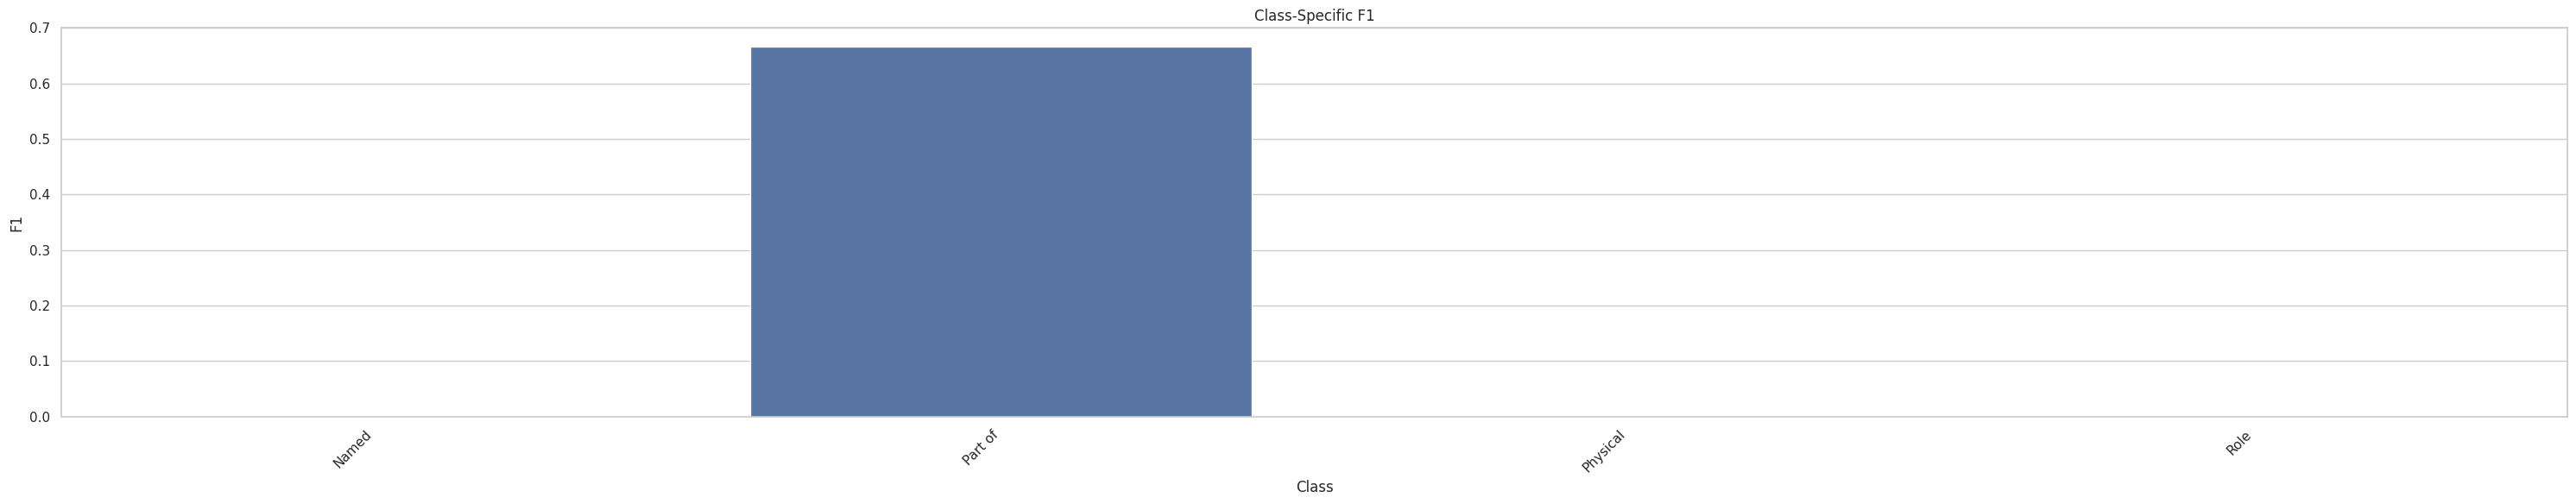

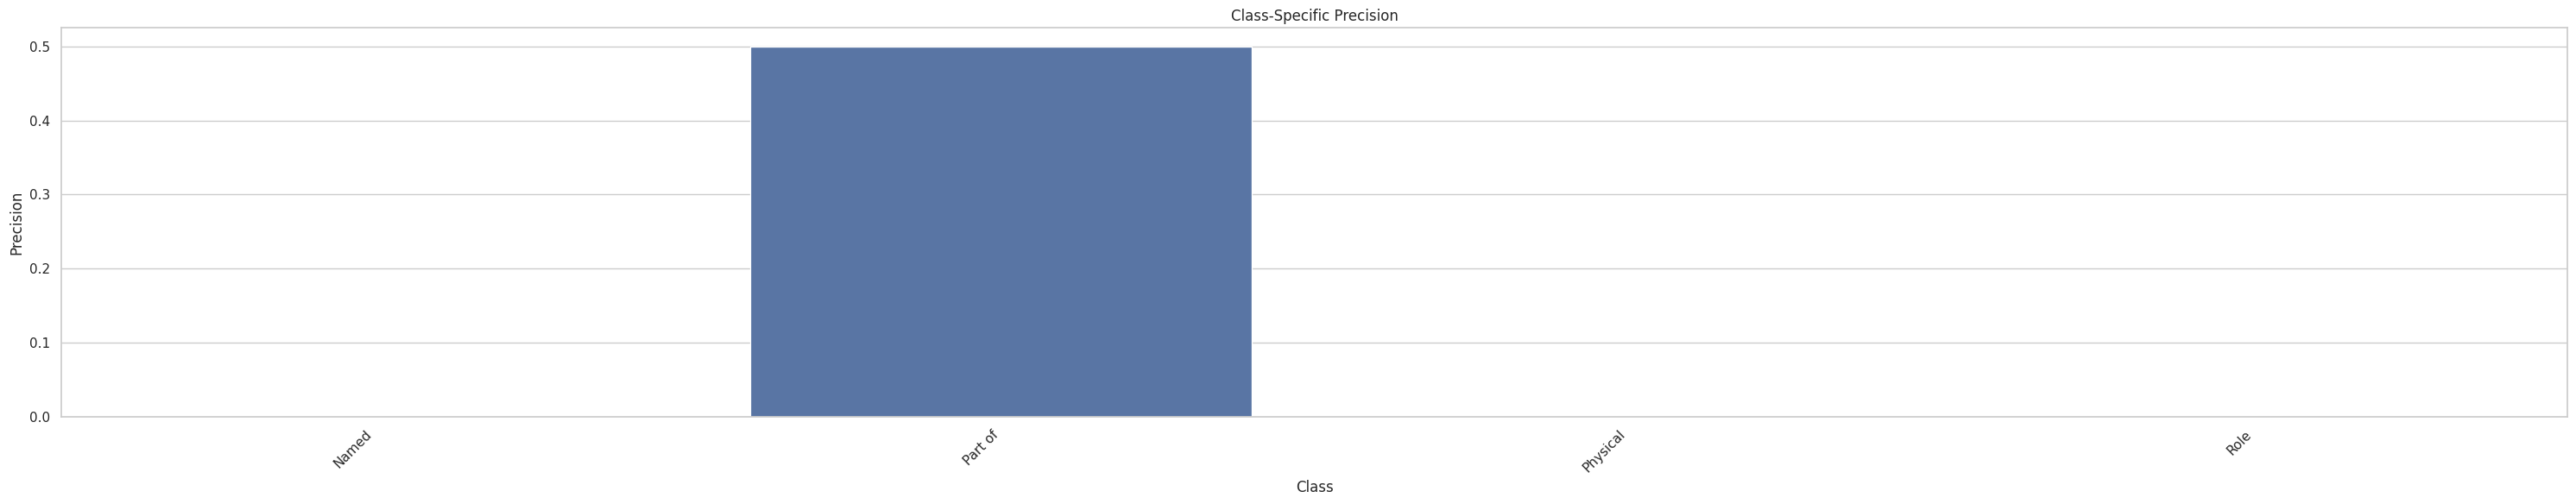

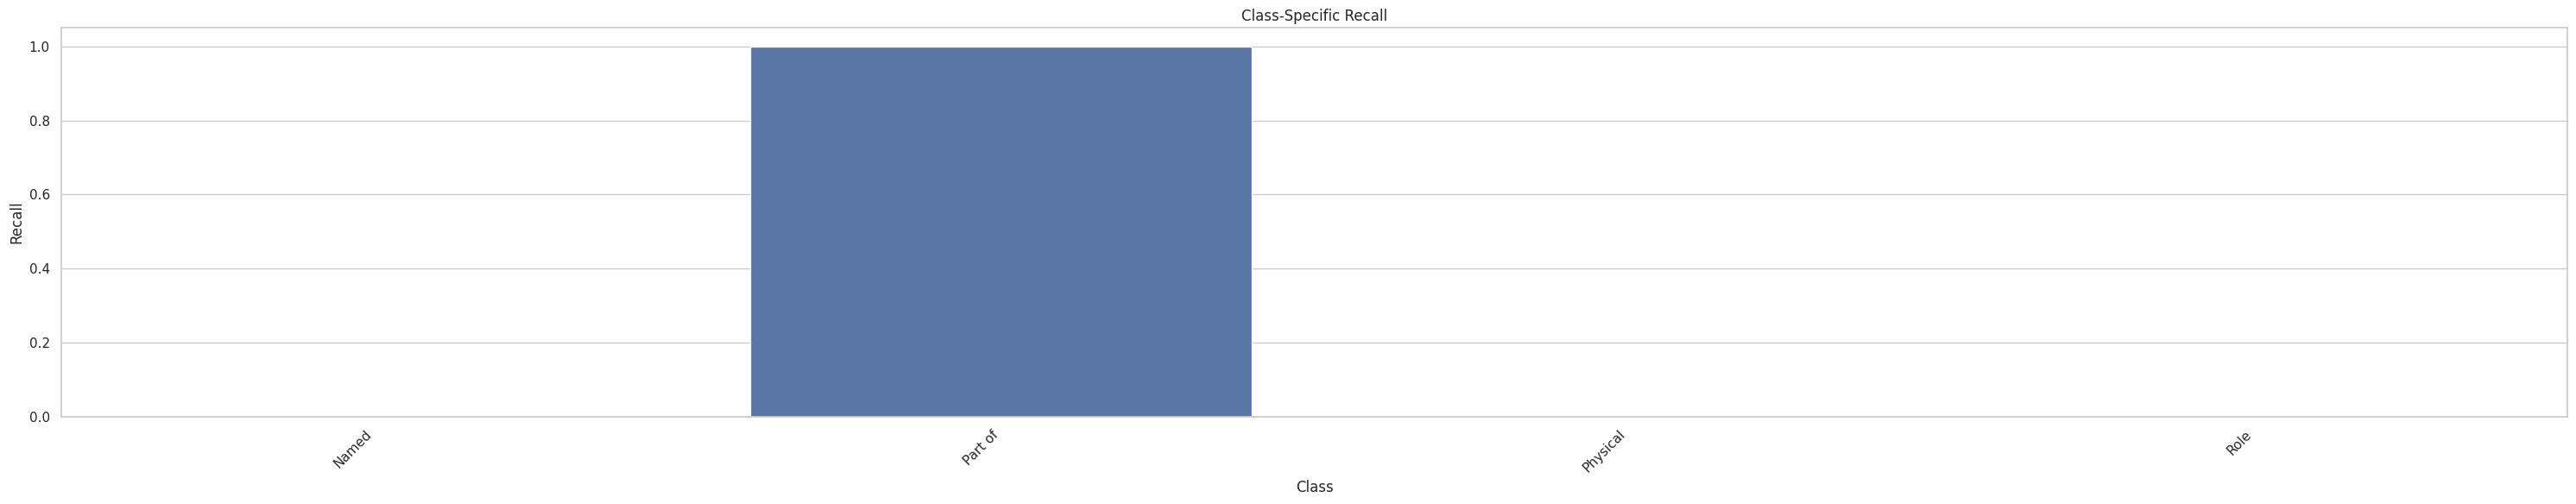

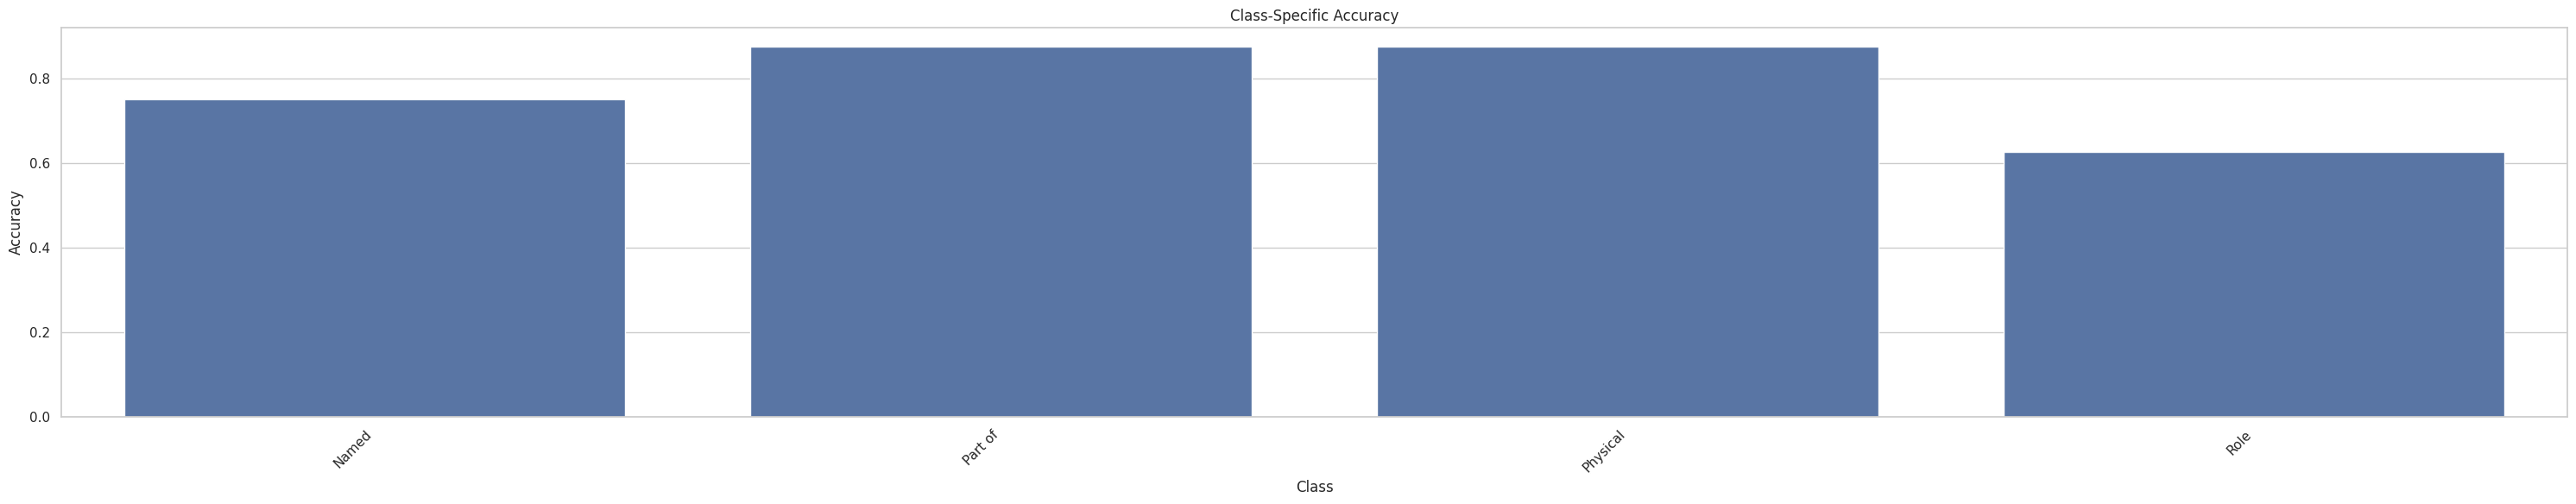

In [36]:
# Assuming you have general_metrics_df and class_metrics_df already created
plot_metrics(general_metrics_df, class_metrics_df)

In [37]:
def average_metrics(score_list):
    # Initialize a dictionary to hold the sum of all metrics
    avg_metrics = {
        'micro_f1': 0,
        'micro_precision': 0,
        'micro_recall': 0,
        'macro_f1': 0,
        'macro_precision': 0,
        'macro_recall': 0,
        'accuracy': 0,
        'class_metrics': {}
    }
    
    if not score_list:  # Check if the list is empty
        return avg_metrics
    
    # First, we gather all classes across all score dictionaries
    all_classes = set()
    for scores in score_list:
        all_classes.update(scores['class_metrics'].keys())
    
    # Initialize the class_metrics to sum the values for each class
    for cls in all_classes:
        avg_metrics['class_metrics'][cls] = {
            'f1': 0,
            'precision': 0,
            'recall': 0,
            'accuracy': 0
        }
    
    # Accumulate metrics across all score dictionaries
    for scores in score_list:
        avg_metrics['micro_f1'] += scores['micro_f1']
        avg_metrics['micro_precision'] += scores['micro_precision']
        avg_metrics['micro_recall'] += scores['micro_recall']
        avg_metrics['macro_f1'] += scores['macro_f1']
        avg_metrics['macro_precision'] += scores['macro_precision']
        avg_metrics['macro_recall'] += scores['macro_recall']
        avg_metrics['accuracy'] += scores['accuracy']
        
        # Accumulate class metrics
        for cls, metrics in scores['class_metrics'].items():
            avg_metrics['class_metrics'][cls]['f1'] += metrics['f1']
            avg_metrics['class_metrics'][cls]['precision'] += metrics['precision']
            avg_metrics['class_metrics'][cls]['recall'] += metrics['recall']
            avg_metrics['class_metrics'][cls]['accuracy'] += metrics['accuracy']
    
    # Calculate averages
    num_scores = len(score_list)
    
    if num_scores > 0:  # Prevent division by zero
        avg_metrics['micro_f1'] /= num_scores
        avg_metrics['micro_precision'] /= num_scores
        avg_metrics['micro_recall'] /= num_scores
        avg_metrics['macro_f1'] /= num_scores
        avg_metrics['macro_precision'] /= num_scores
        avg_metrics['macro_recall'] /= num_scores
        avg_metrics['accuracy'] /= num_scores
    
        # Calculate per-class averages
        for cls in avg_metrics['class_metrics']:
            avg_metrics['class_metrics'][cls]['f1'] /= num_scores
            avg_metrics['class_metrics'][cls]['precision'] /= num_scores
            avg_metrics['class_metrics'][cls]['recall'] /= num_scores
            avg_metrics['class_metrics'][cls]['accuracy'] /= num_scores
    
    return avg_metrics


In [38]:
average_metrics(scores_rels)

{'micro_f1': 0.125,
 'micro_precision': 0.125,
 'micro_recall': 0.125,
 'macro_f1': 0.1111111111111111,
 'macro_precision': 0.16666666666666666,
 'macro_recall': 0.08333333333333333,
 'accuracy': 0.125,
 'class_metrics': {'Named': {'f1': 0.0,
   'precision': 0.0,
   'recall': 0.0,
   'accuracy': 0.75},
  'Physical': {'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'accuracy': 0.875},
  'Part of': {'f1': 0.6666666666666666,
   'precision': 0.5,
   'recall': 1.0,
   'accuracy': 0.875},
  'Role': {'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'accuracy': 0.625}}}

In [39]:
# Function to save the data (scores_rels, general_metrics_df, class_metrics_df) with custom name
def save_data(scores_rels, general_metrics_df, class_metrics_df, folder_path, name):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    
    # Save scores_rels as a pickle file
    scores_rels_filepath = os.path.join(folder_path, f"dspy_{name}_scores_rels.pkl")
    with open(scores_rels_filepath, "wb") as handle:
        pickle.dump(scores_rels, handle)
    
    # Save general_metrics_df as a pickle file
    general_metrics_filepath = os.path.join(folder_path, f"dspy_{name}_general_metrics_df.pkl")
    general_metrics_df.to_pickle(general_metrics_filepath)
    
    # Save class_metrics_df as a pickle file
    class_metrics_filepath = os.path.join(folder_path, f"dspy_{name}_general_class_metrics_df.pkl")
    class_metrics_df.to_pickle(class_metrics_filepath)
    
    # Return the paths of the saved files
    return scores_rels_filepath, general_metrics_filepath, class_metrics_filepath

# Example usage:
# scores_rels, general_metrics_df, class_metrics_df are assumed to be your datasets
#save_data(scores_rels, general_metrics_df, class_metrics_df, "/work3/s174159/LLM_Thesis/plots/data", "dspy_0_shot")



In [40]:
SAMPLE_SIZE

50

## Optimizers (Teleprompters)

In [41]:
from dspy.teleprompt import *

# GPT4oMINI

## 5

In [43]:
tp5 = LabeledFewShot(k=5)
optimized_program_5 = tp5.compile(rel_extractor, trainset=dataset)

In [39]:
optimized_program_5.save("/work3/s174159/LLM_Thesis/prompt/opt_5.json")

In [22]:
optimized_program_5 = rel_extractor
optimized_program_5.load("/work3/s174159/LLM_Thesis/prompt/opt_5.json")

In [44]:
scores_rels = []
results = []

for sam in tqdm(test_data[1], desc="Evaluating test data -- Setting baseline"):
    pred = optimized_program_5(**sam.inputs())
    score= combined_relation_f1_score(sam, pred)
    scores_rels.append(score)

TypeError: 'module' object is not callable

In [ ]:
# Assuming you have general_metrics_df and class_metrics_df already created
general_metrics_df, class_metrics_df = sort_data(scores_rels)
plot_metrics(general_metrics_df, class_metrics_df)
average_metrics(scores_rels)

In [35]:
# Function to save the data (scores_rels, general_metrics_df, class_metrics_df) with custom name
def save_data(scores_rels, general_metrics_df, class_metrics_df, folder_path, name):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    
    # Save scores_rels as a pickle file
    scores_rels_filepath = os.path.join(folder_path, f"dspy_{name}_scores_rels.pkl")
    with open(scores_rels_filepath, "wb") as handle:
        pickle.dump(scores_rels, handle)
    
    # Save general_metrics_df as a pickle file
    general_metrics_filepath = os.path.join(folder_path, f"dspy_{name}_general_metrics_df.pkl")
    general_metrics_df.to_pickle(general_metrics_filepath)
    
    # Save class_metrics_df as a pickle file
    class_metrics_filepath = os.path.join(folder_path, f"dspy_{name}_general_class_metrics_df.pkl")
    class_metrics_df.to_pickle(class_metrics_filepath)
    
    # Return the paths of the saved files
    return scores_rels_filepath, general_metrics_filepath, class_metrics_filepath

# Example usage:
# scores_rels, general_metrics_df, class_metrics_df are assumed to be your datasets
save_data(scores_rels, general_metrics_df, class_metrics_df, "/work3/s174159/LLM_Thesis/plots/data", "5_shot")



('/work3/s174159/LLM_Thesis/plots/data/dspy_10_shot_scores_rels.pkl',
 '/work3/s174159/LLM_Thesis/plots/data/dspy_10_shot_general_metrics_df.pkl',
 '/work3/s174159/LLM_Thesis/plots/data/dspy_10_shot_general_class_metrics_df.pkl')

## 10

In [ ]:
tp10 = BootstrapFewShot(metric=relation_f1_score, max_bootstrapped_demos=10, max_labeled_demos=2, max_rounds=2, teacher_settings=dict(lm=gpt))
optimized_program_10 = tp10.compile(rel_extractor, trainset=dataset, valset=dev_data)

In [ ]:
optimized_program_10.save("/work3/s174159/LLM_Thesis/prompt/opt_10.json")

In [ ]:
scores_rels = []
results = []

for sam in tqdm(test_data, desc="Evaluating test data -- Setting baseline"):
    pred = optimized_program_10(**sam.inputs())
    score= combined_relation_f1_score(sam, pred)
    scores_rels.append(score)

In [ ]:
# Assuming you have general_metrics_df and class_metrics_df already created
general_metrics_df, class_metrics_df = sort_data(scores_rels)
plot_metrics(general_metrics_df, class_metrics_df)
average_metrics(scores_rels)

save_data(scores_rels, general_metrics_df, class_metrics_df, "/work3/s174159/LLM_Thesis/plots/data", "10_shot")

## GPT4

## 0

In [36]:
scores_rels = []
results = []

for x in tqdm(test_data, desc="Evaluating test data -- Setting baseline"):
    pred = rel_extractor(**x.inputs())
    score= combined_relation_f1_score(x, pred)
    scores_rels.append(score)

Evaluating test data -- Setting baseline: 100%|██████████| 50/50 [58:13<00:00, 69.87s/it] 


In [38]:
# Assuming you have general_metrics_df and class_metrics_df already created
#general_metrics_df, class_metrics_df = sort_data(scores_rels)
#plot_metrics(general_metrics_df, class_metrics_df)
#average_metrics(scores_rels)

save_data(scores_rels, general_metrics_df, class_metrics_df, "/work3/s174159/LLM_Thesis/plots/data", "0_shot_GPT4")

('/work3/s174159/LLM_Thesis/plots/data/dspy_0_shot_GPT4_scores_rels.pkl',
 '/work3/s174159/LLM_Thesis/plots/data/dspy_0_shot_GPT4_general_metrics_df.pkl',
 '/work3/s174159/LLM_Thesis/plots/data/dspy_0_shot_GPT4_general_class_metrics_df.pkl')

## 5

In [ ]:
gtp5 = BootstrapFewShot(metric=relation_f1_score, max_bootstrapped_demos=5, max_labeled_demos=0, max_rounds=2, teacher_settings=dict(lm=gpt4))
goptimized_program_5 = gtp5.compile(rel_extractor, trainset=dataset, valset=dev_data)

In [27]:
goptimized_program_5.save("/work3/s174159/LLM_Thesis/prompt/gopt_5.json")

In [31]:
goptimized_program_5 = rel_extractor
goptimized_program_5.load("/work3/s174159/LLM_Thesis/prompt/gopt_5.json")

In [32]:
goptimized_program_5.load("/work3/s174159/LLM_Thesis/prompt/gopt_5.json")

In [ ]:
scores_rels = []
results = []

for sam in tqdm(test_data, desc="Evaluating test data -- Setting baseline"):
    pred = goptimized_program_5(**sam.inputs())
    score= combined_relation_f1_score(sam, pred)
    scores_rels.append(score)
    i = "h"

In [ ]:
# Assuming you have general_metrics_df and class_metrics_df already created
general_metrics_df, class_metrics_df = sort_data(scores_rels)
plot_metrics(general_metrics_df, class_metrics_df)
average_metrics(scores_rels)

In [ ]:
# Function to save the data (scores_rels, general_metrics_df, class_metrics_df) with custom name
def save_data(scores_rels, general_metrics_df, class_metrics_df, folder_path, name):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    
    # Save scores_rels as a pickle file
    scores_rels_filepath = os.path.join(folder_path, f"dspy_{name}_scores_rels.pkl")
    with open(scores_rels_filepath, "wb") as handle:
        pickle.dump(scores_rels, handle)
    
    # Save general_metrics_df as a pickle file
    general_metrics_filepath = os.path.join(folder_path, f"dspy_{name}_general_metrics_df.pkl")
    general_metrics_df.to_pickle(general_metrics_filepath)
    
    # Save class_metrics_df as a pickle file
    class_metrics_filepath = os.path.join(folder_path, f"dspy_{name}_general_class_metrics_df.pkl")
    class_metrics_df.to_pickle(class_metrics_filepath)
    
    # Return the paths of the saved files
    return scores_rels_filepath, general_metrics_filepath, class_metrics_filepath

# Example usage:
# scores_rels, general_metrics_df, class_metrics_df are assumed to be your datasets
save_data(scores_rels, general_metrics_df, class_metrics_df, "/work3/s174159/LLM_Thesis/plots/data", "5_shot_GPT4")



## 10

In [ ]:
gtp10 = BootstrapFewShot(metric=relation_f1_score, max_bootstrapped_demos=10, max_labeled_demos=2, max_rounds=2, teacher_settings=dict(lm=gpt4))
goptimized_program_10 = gtp10.compile(rel_extractor, trainset=dataset, valset=dev_data)

In [27]:
goptimized_program_10.save("/work3/s174159/LLM_Thesis/prompt/gopt_10.json")

In [120]:
goptimized_program_10= rel_extractor
goptimized_program_10.load("/work3/s174159/LLM_Thesis/prompt/gopt_10.json")

In [ ]:
scores_rels = []
results = []

for sam in tqdm(test_data, desc="Evaluating test data -- Setting baseline"):
    pred = goptimized_program_10(**sam.inputs())
    score= combined_relation_f1_score(sam, pred)
    scores_rels.append(score)
    i = "h"

In [ ]:
# Assuming you have general_metrics_df and class_metrics_df already created
general_metrics_df, class_metrics_df = sort_data(scores_rels)
plot_metrics(general_metrics_df, class_metrics_df)
average_metrics(scores_rels)

save_data(scores_rels, general_metrics_df, class_metrics_df, "/work3/s174159/LLM_Thesis/plots/data", "10_shot_GPT4")